Evaluate Japanese tokenization using Amazon esci-data

Pre-requirement

* git clone esci-data
* Start Weaviate server

Index products to Weaviate

* only product_title

With GSE tokenization and Kagome JA tokenization.

1. create collection with GSE
2. index product_title and product_id



In [1]:
import os
import json
import weaviate
from weaviate.classes.config import Property, DataType, Tokenization, Configure

# initialize weaviate client
client = weaviate.connect_to_local(
    host="weaviate",
)
if client.is_ready():
    print("Connected Weaviate server!")

# Create collection with tokenization properties
collection_name = "products"

if client.collections.exists(name=collection_name) == False :
    client.collections.create(
        name=collection_name,
        properties=[
            Property(
                name="product_id",
                data_type=DataType.TEXT,
                skip_vectorization=True,
                index_filterable=True,
                index_searchable=True
            ),
            Property(
                name="title",
                data_type=DataType.TEXT,
                tokenization=Tokenization.GSE,
                skip_vectorization=True,
                index_filterable=True,
                index_searchable=True
            )
        ],
        vectorizer_config=Configure.Vectorizer.none(),
        vector_index_config=Configure.VectorIndex.none()
    )

# Check collection schema
collection = client.collections.get(
    name=collection_name
)
print(collection)


/workspace/.venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.0 at grpc_health/v1/health.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(


Connected Weaviate server!
<weaviate.Collection config={
  "name": "Products",
  "description": null,
  "generative_config": null,
  "inverted_index_config": {
    "bm25": {
      "b": 0.75,
      "k1": 1.2
    },
    "cleanup_interval_seconds": 60,
    "index_null_state": false,
    "index_property_length": false,
    "index_timestamps": false,
    "stopwords": {
      "preset": "en",
      "additions": null,
      "removals": null
    }
  },
  "multi_tenancy_config": {
    "enabled": false,
    "auto_tenant_creation": false,
    "auto_tenant_activation": false
  },
  "properties": [
    {
      "name": "product_id",
      "description": null,
      "data_type": "text",
      "index_filterable": true,
      "index_range_filters": false,
      "index_searchable": true,
      "nested_properties": null,
      "tokenization": "word",
      "vectorizer_config": null,
      "vectorizer": "none"
    },
    {
      "name": "title",
      "description": null,
      "data_type": "text",
      "

In [2]:
import pandas as pd

df_products = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet')
df_products = df_products[df_products["product_locale"] == "jp"]

print(f"# of products = {len(df_products)}")

# of products = 339059


In [3]:
counter = 0
interval = 100000

collection = client.collections.get(
    name=collection_name
)

#with collection.batch.rate_limit(requests_per_minute=500) as batch:
with collection.batch.dynamic() as batch:
    for row in df_products.itertuples():
        if batch.number_errors > 10:
            pass
        product = row._asdict()
        properties = {
            "product_id": product["product_id"],
            "title": product["product_title"]
        }
        batch.add_object(
            properties=properties
        )
        counter += 1
        if counter % interval == 0:
            print(f"Imported {counter} articles...")
    if batch.number_errors != 0 and len(client.batch.failed_objects) == batch.number_errors:
        print(f"Error during batch execution. {batch.number_errors} errors...")
    else :
        print(f"Finished importing {counter} articles.")



Imported 10000 articles...
Imported 20000 articles...
Imported 30000 articles...
Imported 40000 articles...
Imported 50000 articles...
Imported 60000 articles...
Imported 70000 articles...
Imported 80000 articles...
Imported 90000 articles...
Imported 100000 articles...
Imported 110000 articles...
Imported 120000 articles...
Imported 130000 articles...
Imported 140000 articles...
Imported 150000 articles...
Imported 160000 articles...
Imported 170000 articles...
Imported 180000 articles...
Imported 190000 articles...
Imported 200000 articles...
Imported 210000 articles...
Imported 220000 articles...
Imported 230000 articles...
Imported 240000 articles...
Imported 250000 articles...
Imported 260000 articles...
Imported 270000 articles...
Imported 280000 articles...
Imported 290000 articles...
Imported 300000 articles...
Imported 310000 articles...
Imported 320000 articles...
Imported 330000 articles...
Finished importing 339059 articles.


In [4]:

collection.aggregate.over_all(total_count=True).total_count

339059

Prepare quries and judgements data

In [31]:
df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_examples = df_examples[df_examples["product_locale"] == "jp"]
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
# query, query_id
queries: dict[str, str] = {}
# query_id, list(product_id, esci_label, split)
examples: dict[str, list[dict]] = {}

for row in df_examples_products.itertuples():
    product = row._asdict()
    tmp_query = product["query"]
    tmp_query_id = product["query_id"]
    queries[tmp_query_id] = tmp_query
    examples.setdefault(tmp_query_id, [])
    examples[tmp_query_id].append({
        "product_id": product["product_id"],
        "esci_label": product["esci_label"],
        "split": product["split"]
    })

print(f"Load {len(queries)} queries")


Load 18127 queries


Keyword search with Title

In [66]:
from weaviate.classes.query import MetadataQuery

k = 200

# filetr examples by esci_label == E
def exact_relevant_products(examples: list[dict]) -> list:
    relevants = []
    for item in examples:
        if item["esci_label"] == "E":
            relevants.append(item["product_id"])
    return relevants

# calculate recall @ k
def calc_recall(results: list, relevants: list) -> float:
    hits = 0
    for item in results:
        if item.properties["product_id"] in relevants:
            hits = hits+1
    return round(hits / len(relevants), 4)
    
# calculate precision @ k
def calc_precision(results: list, relevants: list) -> float:
    if not results:
        return 0.0
    hits = 0
    for item in results:
        if item.properties["product_id"] in relevants:
            hits = hits+1
    return round(hits / len(results), 4)

# count esci_label category
def count_esci_labels(labels:list) -> str:
    e = s = c = i = 0 
    for label in labels:
        if label["esci_label"] == "E":
            e = e+1
        elif label["esci_label"] == "S":
            s = s+1
        elif label["esci_label"] == "C":
            c = c+1
        elif label["esci_label"] == "I":
            i = i+1
    return f"E:{e}, S:{s}, C:{c}, I:{i}"


def debug_print(query, response, examples, relevants ,recall, precision):
    print(f"query [{query}]")
    print(f"# of objects : {len(response.objects)}")
    print(f"# of relevants : {len(examples[query_id])}")
    print(f"# of relevants : {len(relevants)}")
    print(f"recall    : {recall}")
    print(f"precision : {precision}")
    
stats: list[dict] = []

for (query_id, query) in queries.items():
    response = collection.query.bm25(
        query=query,
        return_metadata=MetadataQuery(score=True),
        limit=k
    )
    relevants = exact_relevant_products(examples=examples[query_id])
    recall = calc_recall(results=response.objects, relevants=relevants)
    precision = calc_precision(results=response.objects, relevants=relevants)
    
    stats.append(
        {
            "query": query,
            "query_id": query_id,
            "k": k,
            "num_of_hits": len(response.objects),
            "num_of_relevants": len(relevants),
            "num_of_examples": len(examples[query_id]),
            "num_of_esci_labels": count_esci_labels(labels=examples[query_id]),
            "recall": recall,
            "precision": precision
        }
    )

pd_stats = pd.DataFrame(stats)
pd_stats



,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
0,&ハニー シャンプー,116,200,200,19,40,"E:19, S:20, C:1, I:0",0.4737,0.045
1,'74ジェイルブレイク ac/dc,123,200,200,8,8,"E:8, S:0, C:0, I:0",0.8750,0.035
2,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,190,200,200,1,40,"E:1, S:7, C:0, I:32",1.0000,0.005
3,(知っていることはあまりないけれど)家族です,191,200,200,1,40,"E:1, S:2, C:0, I:37",1.0000,0.005
4,- ビニール手袋粉なし,295,200,200,29,40,"E:29, S:11, C:0, I:0",0.7931,0.115
...,...,...,...,...,...,...,...,...,...
18122,ﾎﾙｽﾀｰ,130647,200,200,15,16,"E:15, S:0, C:1, I:0",0.0000,0.000
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,200,16,16,"E:16, S:0, C:0, I:0",0.0000,0.000
18124,ﾒｽﾃｨﾝ,130649,200,200,11,16,"E:11, S:0, C:5, I:0",0.0000,0.000
18125,ﾚﾃﾞｨｰｽ水着,130650,200,200,16,16,"E:16, S:0, C:0, I:0",0.0000,0.000


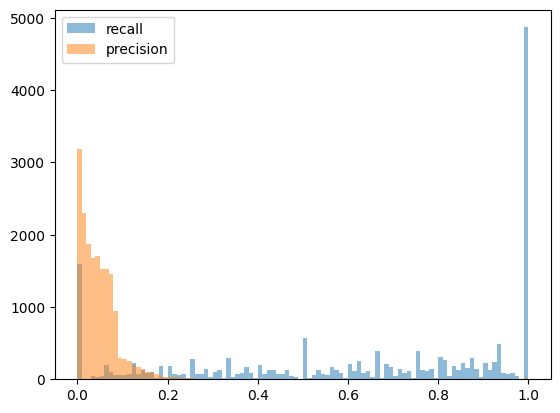

reacll describe.....
count    18127.000000
mean         0.631047
std          0.349548
min          0.000000
25%          0.333300
50%          0.714300
75%          1.000000
max          1.000000
Name: recall, dtype: float64
precision describe.....
count    18127.000000
mean         0.048039
std          0.062090
min          0.000000
25%          0.015000
50%          0.040000
75%          0.065000
max          1.000000
Name: precision, dtype: float64


,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
10869,ホウ酸,123384,200,10,16,16,"E:16, S:0, C:0, I:0",0.6250,1.0
13242,切腹,125757,200,1,1,16,"E:1, S:11, C:0, I:4",1.0000,1.0
14837,明恵,127353,200,15,16,16,"E:16, S:0, C:0, I:0",0.9375,1.0
15055,柳原白蓮,127571,200,14,15,16,"E:15, S:0, C:0, I:1",0.9333,1.0
15377,江副,127893,200,4,7,16,"E:7, S:3, C:0, I:6",0.5714,1.0
15537,清塚 信也,128053,200,1,16,16,"E:16, S:0, C:0, I:0",0.0625,1.0
15933,番線,128449,200,5,5,16,"E:5, S:6, C:0, I:5",1.0000,1.0
17533,雁が音,130054,200,2,10,16,"E:10, S:4, C:0, I:2",0.2000,1.0
17774,頭陀袋,130295,200,8,9,16,"E:9, S:7, C:0, I:0",0.8889,1.0
17906,鬼平,130428,200,16,16,16,"E:16, S:0, C:0, I:0",1.0000,1.0


In [72]:
import matplotlib.pyplot as plt

plt.hist(pd_stats["recall"], bins=100, label="recall", alpha=0.5)
plt.hist(pd_stats["precision"], bins=100, label="precision", alpha=0.5)
plt.legend()
plt.show()

print("reacll describe.....")
print(pd_stats["recall"].describe())
print("precision describe.....")
print(pd_stats["precision"].describe())
pd_stats[pd_stats["precision"] == 1.0]

## 以下、テスト・確認用のスクリプト

In [12]:
df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_examples[df_examples["query_id"] == 1]

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
16,16,!awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train
18,18,!awnmower tires without rims,1,B082K7V2GZ,us,I,1,1,train
19,19,!awnmower tires without rims,1,B07P4CF3DP,us,S,1,1,train
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train
21,21,!awnmower tires without rims,1,B077QMNXTS,us,E,1,1,train
22,22,!awnmower tires without rims,1,B01M3SJ699,us,C,1,1,train
23,23,!awnmower tires without rims,1,B06XX6BM2R,us,E,1,1,train
24,24,!awnmower tires without rims,1,B01DBGLLUC,us,S,1,1,train
25,25,!awnmower tires without rims,1,B00N16T5D8,us,I,1,1,train


In [6]:
import pandas as pd

df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet')
df_sources = pd.read_csv("/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_sources.csv")
df_products = df_products[df_products["product_locale"] == "jp"]
df_examples = df_examples[df_examples["product_locale"] == "jp"]
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
df_examples_products_source = pd.merge(
    df_examples_products,
    df_sources,
    how='left',
    left_on=['query_id'],
    right_on=['query_id']
)
#df_examples_products_source["esci_label"].unique().tolist()
df_examples_products_source[df_examples_products_source["split"] == "test"]

# initialize weaviate client
client = weaviate.connect_to_local(
    host="weaviate",
    headers={
        "X-Google-Studio-Api-Key": os.getenv("GOOGLE_APIKEY")
    }
)
if client.is_ready():
    print("Connected Weaviate server!")

# Create collection with tokenization properties
collection_name = "products"

if client.collections.exists(name=collection_name) == False :
    client.collections.create(
        name=collection_name,
        vectorizer_config=[
            Configure.NamedVectors.text2vec_palm(
                name="title_vector", 
                source_properties=["title"],
                model_id="text-embedding-004",
                api_endpoint="generativelanguage.googleapis.com",
                project_id=""
            )
        ],
        properties=[
            Property(
                name="product_id",
                data_type=DataType.TEXT,
                index_filterable=True,
                index_searchable=True
            ),
            Property(
                name="title",
                data_type=DataType.TEXT,
                tokenization=Tokenization.GSE,
                index_filterable=True,
                index_searchable=True
            )
        ]
    )

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color,source
208,9200,-サングラス,309,B0749LSC8N,jp,E,0,1,test,Duduma 偏光 レンズ メンズスポーツサングラス 超軽量 UV400 紫外線をカット ／...,<b><br>商品紹介<br></b><br><b>1、Dudumaの特別なところのを発見<...,偏光レンズ:99%のUV400保護コーティング、有害な紫外線を100％ブロック、乱反射をカッ...,Duduma,ブラックマットフレーム/ブラックレンズ,other
209,9201,-サングラス,309,B088ZQZCFF,jp,E,0,1,test,scorel 偏光サングラス UV400 紫外線カット 超軽量 スポーツサングラス ドライブ...,None,【超軽量サングラス】:掛け心地に拘り、頭への締めつけ感をなくし、大きいサイズ、小さいサイズい...,scorell,None,other
210,9202,-サングラス,309,B07T13Q1NV,jp,E,0,1,test,MODE des MONDE 【anan掲載モデル】 サングラス メンズ 偏光レンズ UV4...,None,【選ばれるサングラス】偏光性レンズUV400カット / 日本人向けアジアンフィット / 大人...,MODE des MONDE,ブラック,other
211,9203,-サングラス,309,B07Q6N4NGV,jp,E,0,1,test,DUCO サングラス メンズ 偏光 スポーツサングラス UV400 へんこう さんぐらす シ...,<b>DUCOを選んでください！</b><br> DUCOサングラスは、保証される米FDAと...,👓【TAC 偏光 レンズ】：UV400保護コーティングは、有害なUVA&UVB光線を100%...,DUCO,シルバーフレームミラーレンズ,other
212,9204,-サングラス,309,B07CGNRYJ5,jp,E,0,1,test,MARSQUEST 偏光サングラス ウェリントン型 軽量フレーム UV400紫外線・反射光・...,MARSQUEST momentumサングラスは、サンシャインを楽しみ、旅行やショッピングを...,【18g超軽量設計】掛け心地によるストレスを限りなく少なくするため、フレームは軽量で柔軟性が...,MARSQUEST,ブルー,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446048,2621283,�����j�[�h�p�[�x abrasus,130651,B0063ASUY4,jp,E,0,1,test,薄い財布 abrAsus ブッテーロレザーエディション ブラック,2013年グッドデザイン賞受賞。<br/> 「薄い財布abrAsus」は、財布をゼロベースで...,イタリア産の上質なヌメ革を使用した最上級ブッテーロレザーエディション。\nグッドデザイン賞を...,abrAsus(アブラサス),ブラック,other
446049,2621284,�����j�[�h�p�[�x abrasus,130651,B0062EZYIG,jp,E,0,1,test,アブラサス (abrAsus) 薄い財布 ブラック,グッドデザイン賞受賞。 <br /> 「薄い財布abrAsus」は、財布をゼロベースで考えた...,グッドデザイン賞を受賞しました。\n特別な構造（特許取得済み）で、圧倒的な薄さを実現しました...,abrAsus(アブラサス),ブラック,other
446050,2621285,�����j�[�h�p�[�x abrasus,130651,B07H8MWBZN,jp,S,0,1,test,Bellroy Hide & Seek Wallet - スリムなレザー製二つ折り財布、RF...,<b>スリムな財布へ</b><br> ベルロイは、毎日の必需品をスマートに持ち運べる製品の開...,ポケットをフラットに保てるスリムなシルエットかつクラシックなデザイン\nRFID保護（スキミ...,Bellroy(ベルロイ),Black - RFID (New),other
446051,2621286,�����j�[�h�p�[�x abrasus,130651,B00IZH4T9S,jp,E,0,1,test,小さい小銭入れ abrAsus (アブラサス) ダークグリーン,<b>「コイン」「紙幣」「キー」だけを持ち運ぶ キーホルダーみたいな財布</b> <br> ...,「コイン」「紙幣」「キー」だけを一緒に持ち歩く、キーホルダーのような財布です。\n500円玉...,abrAsus(アブラサス),ダークグリーン,other
